In [6]:
# 必要なライブラリの読み込み
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
import scipy.interpolate as sci

# ファイルパスとティッカーシンボル
file_paths = [
    "./gps.us.txt",
    "./rl.us.txt",
    "./abc.us.txt"
]

tickers = ['GPS', 'RL', 'ABC']

# データフレームを保持する辞書
dfs = {}

# GPSデータを読み込んで日付範囲を取得
gps_df = pd.read_csv("./gps.us.txt", usecols=['Date', 'Close']).set_index('Date')
gps_df.index = pd.to_datetime(gps_df.index)
gps_df['GPS'] = gps_df['Close'].pct_change()
dfs['GPS'] = gps_df[['GPS']]

gps_start_date = gps_df.index.min()

# 他のティッカーのデータを読み込み、GPSの開始日以降でフィルタリングし、pct_changeを計算
for file_path, ticker in zip(file_paths[1:], tickers[1:]):  # GPSデータはすでに読み込んでいるのでスキップ
    df = pd.read_csv(file_path, usecols=['Date', 'Close']).set_index('Date')
    df.index = pd.to_datetime(df.index)
    df = df.loc[gps_start_date:]
    df[ticker] = df['Close'].pct_change()
    dfs[ticker] = df[[ticker]]

# すべてのデータフレームをDateインデックスで結合
result_df = pd.concat(dfs.values(), axis=1)

# 結果を表示
print("Daily Stock Price Change Rates (Aligned with GPS Start Date):")
print(result_df.head())



Daily Stock Price Change Rates (Aligned with GPS Start Date):
                 GPS  RL  ABC
Date                         
1987-07-23       NaN NaN  NaN
1987-07-24 -0.013313 NaN  NaN
1987-07-27  0.004426 NaN  NaN
1987-07-28  0.018001 NaN  NaN
1987-07-29  0.026498 NaN  NaN


Annualized Expected Returns (Mu): [0.16833768 0.13013798 0.1975333 ]
Annualized Covariance Matrix (Covs): [[0.16428209 0.05934562 0.02139947]
 [0.05934562 0.12566561 0.02870477]
 [0.02139947 0.02870477 0.1072941 ]]
Risk-Free Rate (rf): 0.03


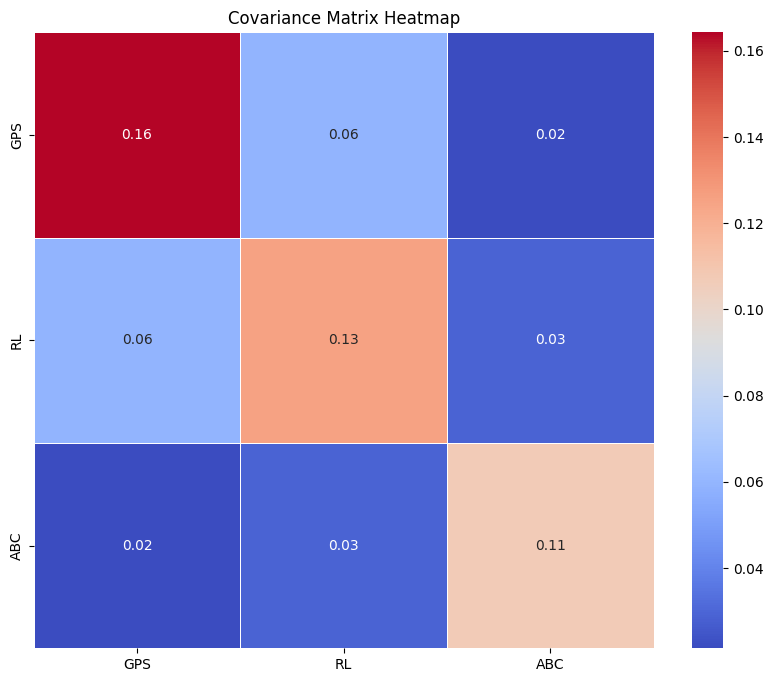

In [5]:
# 年率換算の期待リターンと共分散を計算
Mu = result_df.mean().values * 245
Covs = result_df.cov().values * 245
rf = 0.03

# 年率換算の期待リターンと共分散を表示
print("Annualized Expected Returns (Mu):", Mu)
print("Annualized Covariance Matrix (Covs):", Covs)
print("Risk-Free Rate (rf):", rf)

# 共分散行列からデータフレームを作成してプロット
cov_df = pd.DataFrame(Covs, index=tickers, columns=tickers)

# 共分散行列のヒートマップをプロット
plt.figure(figsize=(10, 8))
sns.heatmap(cov_df, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Covariance Matrix Heatmap')
plt.show()


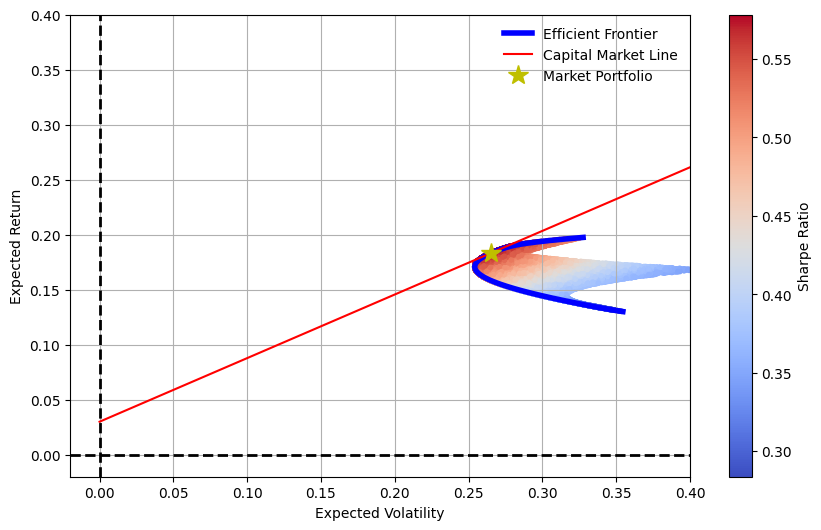

In [7]:
# モンテカルロシミュレーションによるランダムポートフォリオの生成
np.random.seed(999)

def port_ret(weights):
    return np.sum(Mu * weights)

def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(Covs, weights)))

prets = []
pvols = []

for p in range(100000):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    prets.append(port_ret(weights))
    pvols.append(port_vol(weights))

prets = np.array(prets)
pvols = np.array(pvols)

def min_func_sharpe(weights):
    return -(port_ret(weights) - rf) / port_vol(weights)

# シャープレシオの最大化
cons = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(len(tickers)))
eweights = np.array(len(tickers) * [1. / len(tickers),])

opts = sco.minimize(min_func_sharpe, eweights, method='SLSQP', bounds=bnds, constraints=cons)
optimal_weights = opts.x
optimal_return = port_ret(optimal_weights)
optimal_volatility = port_vol(optimal_weights)
optimal_sharpe = (optimal_return - rf) / optimal_volatility

# 効率的フロンティア
def min_func_vol(weights):
    return port_vol(weights)

trets = np.linspace(Mu.min(), Mu.max(), 50)
tvols = []

for tret in trets:
    cons = ({'type':'eq', 'fun': lambda x: port_ret(x) - tret},
            {'type':'eq', 'fun': lambda x: np.sum(x) - 1})
    res = sco.minimize(min_func_vol, eweights, method='SLSQP', bounds=bnds, constraints=cons)
    tvols.append(res['fun'])

tvols = np.array(tvols)

# 効率的フロンティアと資本市場線のプロット
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=(prets - rf) / pvols, marker='.', cmap='coolwarm')
plt.plot(tvols, trets, 'b', lw=4.0, label='Efficient Frontier')
cx = np.linspace(0.0, 0.4, 100)  # CMLのx軸の範囲を拡大
cml_y = rf + optimal_sharpe * cx
plt.plot(cx, cml_y, 'r', lw=1.5, label='Capital Market Line')
plt.plot(optimal_volatility, optimal_return, 'y*', markersize=15.0, label='Market Portfolio')
plt.legend(loc='best', frameon=False)
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlim(-0.02, 0.4)
plt.ylim(-0.02, 0.4)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.show()


In [8]:
# Gradient of capital market line
print("Gradient of Capital Market Line:", optimal_sharpe)

Gradient of Capital Market Line: 0.5783215071039068


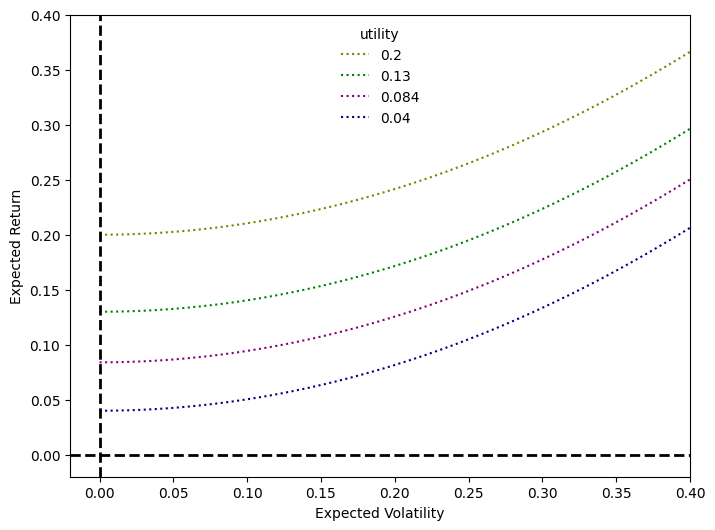

In [9]:
# リスク調整後リターンの計算
def rra_calc(Mu, Covs, weights, rf, a):
    mu_total = weights.dot(Mu)
    var_total = np.dot(weights.dot(Covs), weights.T)
    return (mu_total - rf) / (var_total * a)

np.random.seed(999)
weights = np.random.random(len(tickers))
weights /= np.sum(weights)
a = np.random.random(1)[0]
rra = rra_calc(Mu, Covs, weights, rf, a)

# 効用関数の定義
def u(x, rra, u):
    return (1 / 2) * rra * x ** 2 + u

# 期待ボラティリティの範囲を生成
x = np.linspace(0, np.sqrt(np.diagonal(Covs)).max(), 100)

# 異なるオフセットの効用曲線をプロット
plt.figure(figsize=(8, 6))
plt.plot(x, u(x, rra, 0.2), color="olive", linestyle="dotted", label="0.2")
plt.plot(x, u(x, rra, 0.13), color="g", linestyle="dotted", label="0.13")
plt.plot(x, u(x, rra, 0.084), color="purple", linestyle="dotted", label="0.084")
plt.plot(x, u(x, rra, 0.04), color="navy", linestyle="dotted", label="0.04")
plt.legend(loc='best', frameon=False, title="utility")
plt.xlim(-0.02, 0.4)
plt.ylim(-0.02, 0.4)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.show()


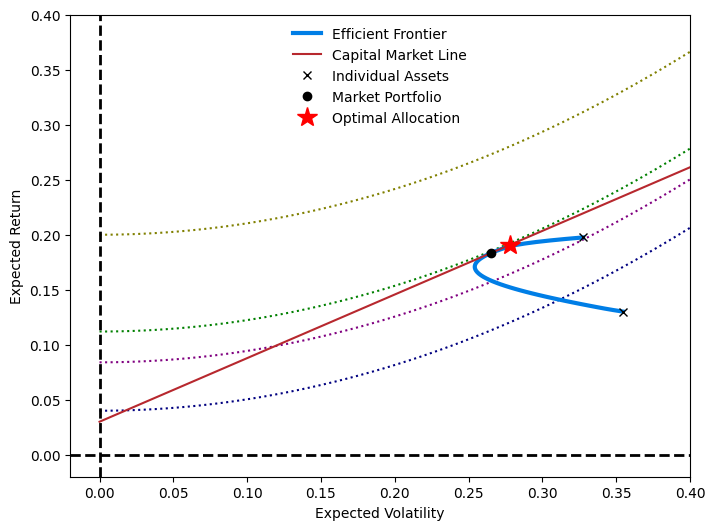

In [15]:
# リスク資産の最適配分
sigma_opt = optimal_sharpe / rra
a_opt = sigma_opt / optimal_volatility
mu_opt = (1 - a_opt) * rf + a_opt * optimal_return

# 最適配分のプロット
plt.figure(figsize=(8, 6))
plt.plot(x, u(x, rra, 0.2), color="olive", linestyle="dotted")
plt.plot(x, u(x, rra, 0.112), color="g", linestyle="dotted")
plt.plot(x, u(x, rra, 0.084), color="purple", linestyle="dotted")
plt.plot(x, u(x, rra, 0.04), color="navy", linestyle="dotted")
plt.plot(tvols, trets, color='#007ee6', lw=3.0, label='Efficient Frontier')
plt.plot(cx, cml_y, color='#b7282e', label='Capital Market Line')
plt.plot(np.sqrt(np.diagonal(Covs)), Mu, 'kx', label='Individual Assets')
plt.plot(optimal_volatility, optimal_return, 'ko', label='Market Portfolio')
plt.plot(sigma_opt, mu_opt, 'r*', markersize=15.0, label='Optimal Allocation')
plt.legend(loc='best', frameon=False)
plt.xlim(-0.02, 0.4)
plt.ylim(-0.02, 0.4)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.show()


In [16]:
# Optimal investment ratio for individual stocks
optimal_ratios = np.abs((optimal_weights * a_opt).round(3))
print("Optimal investment ratios for individual stocks:", optimal_ratios)


Optimal investment ratios for individual stocks: [0.283 0.097 0.669]


In [17]:
# 個別株の最適投資比率を計算
optimal_ratios = np.abs((optimal_weights * a_opt).round(3))
print("Optimal investment ratios for individual stocks:", optimal_ratios)

# 安全資産の割合を計算する関数
def calculate_safe_asset_ratio(optimal_ratios):
    total_investment_ratio = np.sum(optimal_ratios)
    safe_asset_ratio = 1 - total_investment_ratio
    return safe_asset_ratio

# 安全資産の割合を計算
safe_asset_ratio = calculate_safe_asset_ratio(optimal_ratios)
print("Safe asset ratio:", safe_asset_ratio)

Optimal investment ratios for individual stocks: [0.283 0.097 0.669]
Safe asset ratio: -0.04899999999999993
